# A guide to an efficient way to build neural network architectures: Hyperparameter selection and tuning for CNN and Dense Networks using Fashion-MNIST

In [1]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Lambda
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import pandas as pd
np.random.seed(12345)
from keras import optimizers
%matplotlib inline
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from hyperopt import Trials, STATUS_OK, tpe
from keras.datasets import fashion_mnist
from sklearn.model_selection import train_test_split
from keras.layers.core import Activation
from keras.utils import np_utils
from keras.optimizers import RMSprop
from hyperas import optim
from hyperas.distributions import choice, uniform, conditional
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from keras import backend as K
from collections import Counter

C:\Users\Shashank R\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data() #loading the data
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=12345) # train and validation split

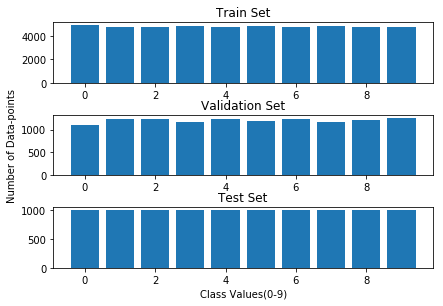

In [3]:
#To check the distribution of classes among the the train,validation and test set
f, (ax1, ax2, ax3) = plt.subplots(3)
f.tight_layout()
x = Counter(y_train).keys()
y = Counter(y_train).values() 
ax1.title.set_text('Train Set')

ax1.bar(x, y)
x = Counter(y_val).keys()
y = Counter(y_val).values()
ax2.title.set_text('Validation Set')
ax2.bar(x,y)
x = Counter(y_test).keys()
y = Counter(y_test).values()
ax3.title.set_text('Test Set')
ax2.set_ylabel('Number of Data-points')
ax3.set_xlabel('Class Values(0-9)')
ax3.bar(x,y)
plt.show()

<b>Observation:-</b> The dataset is balanced as we have nearly the same amount of datapoints in every class.

As we would be working at first with dense neural networks we need to do a little pre-processing of the data before we input them to the networks. This involves:-

- Changing the shape of the train validate and test data from 28X28 format to a list of 784 values
- Normalizing our input so that the input values range from 0 to 1 rather than 0 to 255, Standardization can also be done

## Pre-processing Data

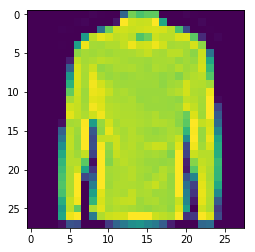

In [4]:
#Having a look at a data-point
plt.imshow(X_train[1, :].reshape((28, 28)))

In [5]:
X_train.shape

(48000, 28, 28)

In [6]:
X_train = X_train.reshape(48000, 784)
X_val = X_val.reshape(12000, 784)
X_test = X_test.reshape(10000, 784)
X_train = X_train.astype('float32')
X_val = X_val.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_val /= 255
X_test/= 255

The class-labels are now converted to catergorical variables which are one-hot encoded, not required if you use sparse categorical entropy as your loss

In [7]:
nb_classes = 10
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_val = np_utils.to_categorical(y_val, nb_classes)
Y_test= np_utils.to_categorical(y_test, nb_classes)

## Training Models

In [8]:
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []
        self.train_acc=[]
        self.val_acc=[]
        self.losses_e = []
        self.val_losses_e = []
        self.train_acc_e=[]
        self.val_acc_e=[]
        
    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.train_acc.append(logs.get('acc'))
    
    def on_epoch_end(self, epoch, logs={}):
        self.losses_e.append(logs.get('loss'))
        self.val_losses_e.append(logs.get('val_loss'))
        self.train_acc_e.append(logs.get('acc'))
        self.val_acc_e.append(logs.get('val_acc'))

In [9]:
model = Sequential([
    Dense(10,input_shape=(784,),activation='softmax')
])

In [10]:
model.compile(optimizer=keras.optimizers.SGD(lr=0.1),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [11]:
softmax_loss_val = LossHistory()

softmax_eval = model.fit(X_train, Y_train,
                    batch_size=256,
                    epochs=40,
                    verbose=1,
                    validation_data=(X_val, Y_val),
                    callbacks=[softmax_loss_val])

Train on 48000 samples, validate on 12000 samples
Epoch 1/40
48000/48000 [==============================] - 5s 102us/step - loss: 0.8316 - acc: 0.7345 - val_loss: 0.6480 - val_acc: 0.7853
Epoch 2/40
48000/48000 [==============================] - 2s 39us/step - loss: 0.5958 - acc: 0.8025 - val_loss: 0.5608 - val_acc: 0.8223
Epoch 3/40
48000/48000 [==============================] - 2s 40us/step - loss: 0.5467 - acc: 0.8164 - val_loss: 0.5297 - val_acc: 0.8279
Epoch 4/40
48000/48000 [==============================] - 2s 39us/step - loss: 0.5195 - acc: 0.8258 - val_loss: 0.5108 - val_acc: 0.8290
Epoch 5/40
48000/48000 [==============================] - 2s 39us/step - loss: 0.5022 - acc: 0.8304 - val_loss: 0.4929 - val_acc: 0.8360
Epoch 6/40
48000/48000 [==============================] - 2s 39us/step - loss: 0.4899 - acc: 0.8333 - val_loss: 0.4778 - val_acc: 0.8424
Epoch 7/40
48000/48000 [==============================] - 2s 38us/step - loss: 0.4786 - acc: 0.8376 - val_loss: 0.4686 - val_ac

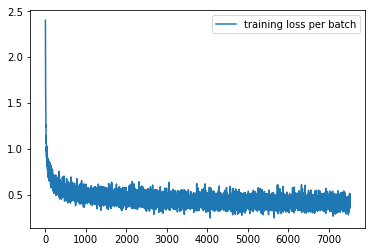

In [12]:
plt.plot(softmax_loss_val.losses,label='training loss per batch')
plt.legend()
plt.show()

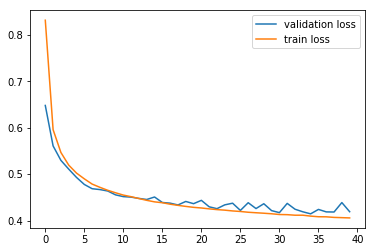

In [13]:
plt.plot(softmax_loss_val.val_losses_e,label='validation loss')
plt.plot(softmax_loss_val.losses_e,label='train loss')
plt.legend()
plt.show()

In [14]:
prediction = model.predict_classes(X_train)
confusion_matrix(y_train, prediction)

array([[3875,   11,   49,  247,   13,    6,  658,    1,   43,    2],
       [   7, 4592,   15,  115,   12,    0,   28,    0,    3,    0],
       [  45,   11, 3203,   44,  726,    2,  699,    0,   33,    1],
       [ 124,   36,   22, 4296,  156,    0,  190,    1,   10,    0],
       [   8,    2,  215,  151, 3853,    1,  514,    0,   16,    0],
       [   2,    0,    0,    1,    0, 4506,    1,  183,   29,   99],
       [ 488,   13,  353,  123,  397,    0, 3342,    1,   62,    0],
       [   0,    0,    0,    0,    0,  153,    0, 4462,   13,  198],
       [  13,    4,   15,   35,   14,   27,  108,   21, 4554,    5],
       [   0,    1,    0,    1,    0,   56,    2,  141,    5, 4536]],
      dtype=int64)

In [15]:
prediction = model.predict_classes(X_val)
confusion_matrix(y_val, prediction)

array([[ 868,    3,   11,   47,    5,    0,  144,    0,   16,    1],
       [   4, 1179,    6,   26,    3,    0,    9,    1,    0,    0],
       [  19,    1,  832,   11,  170,    1,  194,    0,    8,    0],
       [  39,   13,    8, 1022,   38,    0,   41,    0,    4,    0],
       [   0,    0,   67,   33,  988,    0,  146,    0,    6,    0],
       [   4,    0,    0,    1,    0, 1095,    1,   49,    9,   20],
       [ 123,    4,   86,   32,   98,    0,  858,    0,   19,    1],
       [   0,    0,    0,    0,    0,   40,    0, 1078,    1,   55],
       [   2,    0,    3,   14,    6,   11,   31,    3, 1133,    1],
       [   1,    0,    0,    0,    0,   14,    0,   32,    2, 1209]],
      dtype=int64)

In [16]:
prediction = model.predict_classes(X_test)
confusion_matrix(y_test, prediction)

array([[767,   3,  13,  55,   5,   0, 144,   0,  13,   0],
       [  2, 950,   3,  30,   6,   0,   8,   0,   1,   0],
       [ 17,   4, 651,   8, 158,   1, 152,   0,   9,   0],
       [ 21,  11,  10, 865,  29,   1,  59,   0,   4,   0],
       [  0,   1,  64,  37, 776,   1, 112,   0,   9,   0],
       [  0,   0,   0,   2,   0, 916,   0,  48,   4,  30],
       [107,   1,  88,  38,  95,   1, 643,   0,  27,   0],
       [  0,   0,   0,   0,   0,  34,   0, 918,   0,  48],
       [  3,   1,   5,  12,   3,   5,  28,   5, 938,   0],
       [  0,   0,   0,   0,   0,  12,   1,  35,   1, 951]], dtype=int64)

In [17]:
score = model.evaluate(X_train, Y_train, verbose=0)
print('Train loss:', score[0])
print('Train accuracy:', score[1])
print('-------------------------------')
score = model.evaluate(X_val, Y_val, verbose=0)
print('Validation loss:', score[0])
print('Validation accuracy:', score[1])
print('-------------------------------')
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train loss: 0.4080537807593743
Train accuracy: 0.8587291666666667
-------------------------------
Validation loss: 0.41903533510367075
Validation accuracy: 0.8551666666666666
-------------------------------
Test loss: 0.4566255188465118
Test accuracy: 0.8375


In [18]:
def data():
    (X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=12345)
    X_train = X_train.reshape(48000, 784)
    X_val = X_val.reshape(12000, 784)
    X_train = X_train.astype('float32')
    X_val = X_val.astype('float32')
    
    X_train /= 255
    X_val /= 255
    nb_classes = 10
    Y_train = np_utils.to_categorical(y_train, nb_classes)
    Y_val = np_utils.to_categorical(y_val, nb_classes)
    return X_train, Y_train, X_val, Y_val

In [19]:
def model(X_train, Y_train, X_val, Y_val):
    
    model = Sequential()
    model.add(Dense({{choice([128, 256, 512, 1024])}}, input_shape=(784,)))
    model.add(Activation({{choice(['relu', 'sigmoid'])}}))
    model.add(Dropout({{uniform(0, 1)}}))
    model.add(Dense({{choice([128, 256, 512, 1024])}}))
    model.add(Activation({{choice(['relu', 'sigmoid'])}}))
    model.add(Dropout({{uniform(0, 1)}}))
    
    if conditional({{choice(['two', 'three'])}}) == 'three':
        model.add(Dense({{choice([128, 256, 512, 1024])}}))
        model.add(Activation({{choice(['relu', 'sigmoid'])}}))
        model.add(Dropout({{uniform(0, 1)}}))
        

    model.add(Dense(10))
    model.add(Activation('softmax'))

    adam = keras.optimizers.Adam(lr={{choice([10**-3, 10**-2, 10**-1])}})
    rmsprop = keras.optimizers.RMSprop(lr={{choice([10**-3, 10**-2, 10**-1])}})
    sgd = keras.optimizers.SGD(lr={{choice([10**-3, 10**-2, 10**-1])}})
   
    choiceval = {{choice(['adam', 'sgd', 'rmsprop'])}}
    if choiceval == 'adam':
        optim = adam
    elif choiceval == 'rmsprop':
        optim = rmsprop
    else:
        optim = sgd
        
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'],
                  optimizer=optim)

    model.fit(X_train, Y_train,
              batch_size={{choice([128,256,512])}},
              nb_epoch=20,
              verbose=2,
              validation_data=(X_val, Y_val))
    score, acc = model.evaluate(X_val, Y_val, verbose=0)
    print('Test accuracy:', acc)
    return {'loss': -acc, 'status': STATUS_OK, 'model': model}

In [6]:
X_train, Y_train, X_val, Y_val = data()

best_run, best_model = optim.minimize(model=model,
                                      data=data,
                                      algo=tpe.suggest,
                                      max_evals=20,
                                      trials=Trials(),
                                      notebook_name='Fashion_MNIST')

>>> Imports:
#coding=utf-8

try:
    import keras
except:
    pass

try:
    from keras.models import Sequential
except:
    pass

try:
    from keras.layers import Dense, Dropout, Flatten, Lambda
except:
    pass

try:
    from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
except:
    pass

try:
    import matplotlib.pyplot as plt
except:
    pass

try:
    import matplotlib.image as mpimg
except:
    pass

try:
    from keras.preprocessing.image import ImageDataGenerator
except:
    pass

try:
    import numpy as np
except:
    pass

try:
    import pandas as pd
except:
    pass

try:
    from keras import optimizers
except:
    pass

try:
    from sklearn.model_selection import GridSearchCV
except:
    pass

try:
    from keras.wrappers.scikit_learn import KerasClassifier
except:
    pass

try:
    from hyperopt import Trials, STATUS_OK, tpe
except:
    pass

try:
    from keras.datasets import fashion_mnist
except:
    pass

try:
    from sklearn.model_selection impo

C:\Users\Shashank R\Anaconda3\lib\site-packages\keras\models.py:942: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 48000 samples, validate on 12000 samples
Epoch 1/20
 - 3s - loss: 1.1945 - acc: 0.5773 - val_loss: 0.7621 - val_acc: 0.7291
Epoch 2/20
 - 1s - loss: 0.7237 - acc: 0.7317 - val_loss: 0.6320 - val_acc: 0.7488
Epoch 3/20
 - 1s - loss: 0.6332 - acc: 0.7642 - val_loss: 0.6110 - val_acc: 0.7716
Epoch 4/20
 - 1s - loss: 0.5912 - acc: 0.7837 - val_loss: 0.5455 - val_acc: 0.8017
Epoch 5/20
 - 1s - loss: 0.5568 - acc: 0.7961 - val_loss: 0.5089 - val_acc: 0.8221
Epoch 6/20
 - 1s - loss: 0.5302 - acc: 0.8057 - val_loss: 0.5006 - val_acc: 0.8162
Epoch 7/20
 - 1s - loss: 0.5156 - acc: 0.8097 - val_loss: 0.4934 - val_acc: 0.8210
Epoch 8/20
 - 1s - loss: 0.5032 - acc: 0.8162 - val_loss: 0.4564 - val_acc: 0.8390
Epoch 9/20
 - 1s - loss: 0.4884 - acc: 0.8233 - val_loss: 0.4472 - val_acc: 0.8443
Epoch 10/20
 - 1s - loss: 0.4778 - acc: 0.8262 - val_loss: 0.4397 - val_acc: 0.8432
Epoch 11/20
 - 1s - loss: 0.4689 - acc: 0.8303 - val_loss: 0.4316 - val_acc: 0.8505
Epoch 12/20
 - 1s - loss: 0.4600 - 

Epoch 14/20
 - 1s - loss: 14.5198 - acc: 0.0991 - val_loss: 14.4579 - val_acc: 0.1030
Epoch 15/20
 - 1s - loss: 14.5190 - acc: 0.0991 - val_loss: 14.4579 - val_acc: 0.1030
Epoch 16/20
 - 1s - loss: 14.5087 - acc: 0.0998 - val_loss: 14.4579 - val_acc: 0.1030
Epoch 17/20
 - 1s - loss: 14.5130 - acc: 0.0996 - val_loss: 14.4579 - val_acc: 0.1030
Epoch 18/20
 - 1s - loss: 14.5140 - acc: 0.0995 - val_loss: 14.4579 - val_acc: 0.1030
Epoch 19/20
 - 1s - loss: 14.5130 - acc: 0.0996 - val_loss: 14.4579 - val_acc: 0.1030
Epoch 20/20
 - 1s - loss: 14.5126 - acc: 0.0995 - val_loss: 14.4579 - val_acc: 0.1030
Test accuracy: 0.103
Train on 48000 samples, validate on 12000 samples
Epoch 1/20
 - 2s - loss: 14.4449 - acc: 0.0997 - val_loss: 14.5009 - val_acc: 0.1003
Epoch 2/20
 - 1s - loss: 14.5076 - acc: 0.0999 - val_loss: 14.5009 - val_acc: 0.1003
Epoch 3/20
 - 1s - loss: 14.5076 - acc: 0.0999 - val_loss: 14.5009 - val_acc: 0.1003
Epoch 4/20
 - 1s - loss: 14.5076 - acc: 0.0999 - val_loss: 14.5009 - val

Epoch 6/20
 - 2s - loss: 0.7440 - acc: 0.7334 - val_loss: 0.5237 - val_acc: 0.8401
Epoch 7/20
 - 2s - loss: 0.7354 - acc: 0.7381 - val_loss: 0.4965 - val_acc: 0.8452
Epoch 8/20
 - 2s - loss: 0.7276 - acc: 0.7429 - val_loss: 0.5051 - val_acc: 0.8435
Epoch 9/20
 - 2s - loss: 0.7215 - acc: 0.7481 - val_loss: 0.4794 - val_acc: 0.8491
Epoch 10/20
 - 2s - loss: 0.7109 - acc: 0.7493 - val_loss: 0.4959 - val_acc: 0.8473
Epoch 11/20
 - 2s - loss: 0.7132 - acc: 0.7508 - val_loss: 0.4889 - val_acc: 0.8545
Epoch 12/20
 - 2s - loss: 0.7135 - acc: 0.7502 - val_loss: 0.4790 - val_acc: 0.8517
Epoch 13/20
 - 2s - loss: 0.7055 - acc: 0.7556 - val_loss: 0.4774 - val_acc: 0.8540
Epoch 14/20
 - 2s - loss: 0.7026 - acc: 0.7546 - val_loss: 0.4647 - val_acc: 0.8518
Epoch 15/20
 - 2s - loss: 0.7023 - acc: 0.7565 - val_loss: 0.4638 - val_acc: 0.8550
Epoch 16/20
 - 2s - loss: 0.7024 - acc: 0.7574 - val_loss: 0.4806 - val_acc: 0.8540
Epoch 17/20
 - 2s - loss: 0.6970 - acc: 0.7591 - val_loss: 0.4827 - val_acc: 0.8

Epoch 20/20
 - 1s - loss: 14.5076 - acc: 0.0999 - val_loss: 14.5009 - val_acc: 0.1003
Test accuracy: 0.10033333333333333
Train on 48000 samples, validate on 12000 samples
Epoch 1/20
 - 2s - loss: 2.3843 - acc: 0.1002 - val_loss: 2.2986 - val_acc: 0.1050
Epoch 2/20
 - 1s - loss: 2.3155 - acc: 0.1076 - val_loss: 2.3014 - val_acc: 0.0763
Epoch 3/20
 - 1s - loss: 2.3068 - acc: 0.1073 - val_loss: 2.3010 - val_acc: 0.0975
Epoch 4/20
 - 1s - loss: 2.3025 - acc: 0.1100 - val_loss: 2.2997 - val_acc: 0.0971
Epoch 5/20
 - 1s - loss: 2.3000 - acc: 0.1139 - val_loss: 2.2971 - val_acc: 0.0971
Epoch 6/20
 - 1s - loss: 2.2979 - acc: 0.1160 - val_loss: 2.2915 - val_acc: 0.1927
Epoch 7/20
 - 1s - loss: 2.2920 - acc: 0.1213 - val_loss: 2.2779 - val_acc: 0.1948
Epoch 8/20
 - 1s - loss: 2.2875 - acc: 0.1263 - val_loss: 2.2660 - val_acc: 0.2000
Epoch 9/20
 - 1s - loss: 2.2791 - acc: 0.1318 - val_loss: 2.2483 - val_acc: 0.2184
Epoch 10/20
 - 1s - loss: 2.2659 - acc: 0.1370 - val_loss: 2.2212 - val_acc: 0.230

Epoch 14/20
 - 1s - loss: 0.4012 - acc: 0.8546 - val_loss: 0.3373 - val_acc: 0.8763
Epoch 15/20
 - 1s - loss: 0.3986 - acc: 0.8554 - val_loss: 0.3357 - val_acc: 0.8829
Epoch 16/20
 - 1s - loss: 0.3921 - acc: 0.8585 - val_loss: 0.3374 - val_acc: 0.8821
Epoch 17/20
 - 1s - loss: 0.3897 - acc: 0.8593 - val_loss: 0.3454 - val_acc: 0.8756
Epoch 18/20
 - 1s - loss: 0.3878 - acc: 0.8598 - val_loss: 0.3209 - val_acc: 0.8832
Epoch 19/20
 - 1s - loss: 0.3853 - acc: 0.8606 - val_loss: 0.3272 - val_acc: 0.8866
Epoch 20/20
 - 1s - loss: 0.3813 - acc: 0.8626 - val_loss: 0.3167 - val_acc: 0.8878
Test accuracy: 0.8878333333333334
Train on 48000 samples, validate on 12000 samples
Epoch 1/20
 - 2s - loss: 1.9061 - acc: 0.3460 - val_loss: 1.3472 - val_acc: 0.6567
Epoch 2/20
 - 1s - loss: 1.3255 - acc: 0.5684 - val_loss: 0.9963 - val_acc: 0.6799
Epoch 3/20
 - 1s - loss: 1.0878 - acc: 0.6319 - val_loss: 0.8562 - val_acc: 0.7083
Epoch 4/20
 - 1s - loss: 0.9704 - acc: 0.6636 - val_loss: 0.7843 - val_acc: 0.7

In [7]:
print("Best performing model chosen hyper-parameters:")
print(best_run)

Best performing model chosen hyper-parameters:
{'Activation': 0, 'Activation_1': 0, 'Activation_2': 0, 'Dense': 3, 'Dense_1': 3, 'Dense_2': 1, 'Dropout': 0.6346993188487943, 'Dropout_1': 0.3471522714859784, 'Dropout_2': 0.42208889978571484, 'batch_size': 1, 'choiceval': 0, 'conditional': 1, 'lr': 0, 'lr_1': 1, 'lr_2': 1}


In [21]:
model = Sequential([
    Dense(1024, input_shape=(784,), activation='relu'),
    Dropout(0.63),
    Dense(1024, activation='relu'),
    Dropout(0.35),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.42),
    Dense(10, activation='softmax')
])

In [22]:
model.compile(optimizer=keras.optimizers.Adam(lr=0.001),
              loss='categorical_crossentropy',
              metrics=['acc'])

In [23]:
nn_intuition_loss_val = LossHistory()

nn_intuition_eval = model.fit(X_train, Y_train,
                    batch_size=256,
                    epochs=40,
                    verbose=1,
                    validation_data=(X_val, Y_val),
                    callbacks=[nn_intuition_loss_val])

Train on 48000 samples, validate on 12000 samples
Epoch 1/40
48000/48000 [==============================] - 3s 59us/step - loss: 0.8288 - acc: 0.7139 - val_loss: 0.4518 - val_acc: 0.8409
Epoch 2/40
48000/48000 [==============================] - 2s 44us/step - loss: 0.5402 - acc: 0.8037 - val_loss: 0.4223 - val_acc: 0.8528
Epoch 3/40
48000/48000 [==============================] - 2s 42us/step - loss: 0.4877 - acc: 0.8208 - val_loss: 0.3686 - val_acc: 0.8704
Epoch 4/40
48000/48000 [==============================] - 2s 42us/step - loss: 0.4563 - acc: 0.8317 - val_loss: 0.3691 - val_acc: 0.8640
Epoch 5/40
48000/48000 [==============================] - 2s 41us/step - loss: 0.4344 - acc: 0.8410 - val_loss: 0.3384 - val_acc: 0.8800
Epoch 6/40
48000/48000 [==============================] - 2s 42us/step - loss: 0.4235 - acc: 0.8438 - val_loss: 0.3436 - val_acc: 0.8787
Epoch 7/40
48000/48000 [==============================] - 2s 42us/step - loss: 0.4099 - acc: 0.8504 - val_loss: 0.3374 - val_acc

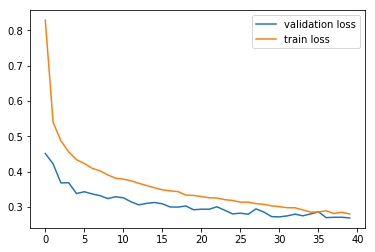

In [25]:
plt.plot(nn_intuition_loss_val.val_losses_e,label='validation loss')
plt.plot(nn_intuition_loss_val.losses_e,label='train loss')
plt.legend()
plt.show()

In [26]:
prediction = model.predict_classes(X_train)
confusion_matrix(y_train, prediction)

array([[4108,    3,   34,   85,    5,    0,  664,    0,    6,    0],
       [   1, 4721,    1,   41,    1,    0,    6,    0,    1,    0],
       [  24,    0, 3977,   58,  305,    0,  394,    0,    6,    0],
       [  60,   12,    8, 4642,   55,    0,   52,    0,    6,    0],
       [   2,    3,  383,  270, 3799,    0,  295,    0,    8,    0],
       [   0,    0,    0,    0,    0, 4791,    0,   28,    0,    2],
       [ 370,    2,  216,   95,  181,    0, 3904,    0,   11,    0],
       [   0,    0,    0,    0,    0,   14,    0, 4766,    0,   46],
       [   3,    1,    5,    8,    6,    0,   20,    0, 4753,    0],
       [   0,    0,    0,    0,    0,   12,    0,  170,    0, 4560]],
      dtype=int64)

In [27]:
prediction = model.predict_classes(X_val)
confusion_matrix(y_val, prediction)

array([[ 882,    1,    7,   16,    0,    0,  181,    0,    8,    0],
       [   3, 1212,    3,    8,    1,    0,    1,    0,    0,    0],
       [  13,    0, 1013,   12,   65,    0,  131,    0,    2,    0],
       [  16,    6,    3, 1088,   19,    0,   25,    0,    8,    0],
       [   0,    0,  106,   64,  966,    0,   99,    0,    5,    0],
       [   0,    0,    0,    0,    0, 1149,    0,   21,    2,    7],
       [  88,    0,   53,   27,   56,    0,  989,    1,    7,    0],
       [   0,    0,    0,    0,    0,   17,    0, 1138,    2,   17],
       [   2,    0,    1,    3,    2,    2,    7,    1, 1186,    0],
       [   1,    0,    0,    0,    0,   11,    0,   44,    0, 1202]],
      dtype=int64)

In [28]:
prediction = model.predict_classes(X_test)
confusion_matrix(y_test, prediction)

array([[793,   2,   7,  30,   3,   1, 160,   0,   4,   0],
       [  3, 974,   0,  17,   2,   0,   2,   0,   2,   0],
       [ 13,   1, 802,  11,  75,   0,  98,   0,   0,   0],
       [ 19,   6,   6, 921,  16,   0,  27,   0,   5,   0],
       [  0,   0, 109,  60, 753,   0,  76,   0,   2,   0],
       [  0,   0,   0,   0,   0, 970,   0,  21,   1,   8],
       [ 90,   0,  60,  33,  51,   0, 759,   0,   7,   0],
       [  0,   0,   0,   0,   0,  10,   0, 979,   0,  11],
       [  3,   0,   2,   5,   1,   1,   5,   4, 979,   0],
       [  0,   0,   0,   0,   0,   5,   1,  45,   0, 949]], dtype=int64)

In [29]:
score = model.evaluate(X_train, Y_train, verbose=0)
print('Train loss:', score[0])
print('Train accuracy:', score[1])
print('-------------------------------')
score = model.evaluate(X_val, Y_val, verbose=0)
print('Validation loss:', score[0])
print('Validation accuracy:', score[1])
print('-------------------------------')
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train loss: 0.21897427964458863
Train accuracy: 0.9171041666666667
-------------------------------
Validation loss: 0.2695253123144309
Validation accuracy: 0.9020833333333333
-------------------------------
Test loss: 0.31117868974208834
Test accuracy: 0.8879


In [30]:
model = Sequential([
    Dense(1024, input_shape=(784,), activation='relu',kernel_initializer='he_normal'),
    Dropout(0.63),
    Dense(1024, activation='relu',kernel_initializer='he_normal'),
    Dropout(0.35),
    Dense(256, activation='relu',kernel_initializer='he_normal'),
    BatchNormalization(),
    Dropout(0.42),
    Dense(10, activation='softmax')
])

In [31]:
model.compile(optimizer=keras.optimizers.Adam(lr=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [32]:
nn_relu_gu_loss_val = LossHistory()

nn_relu_gu_eval = model.fit(X_train, Y_train,
                    batch_size=256,
                    epochs=40,
                    verbose=1,
                    validation_data=(X_val, Y_val),
                    callbacks=[nn_relu_gu_loss_val])

Train on 48000 samples, validate on 12000 samples
Epoch 1/40
48000/48000 [==============================] - 3s 59us/step - loss: 0.8503 - acc: 0.7069 - val_loss: 0.4979 - val_acc: 0.8127
Epoch 2/40
48000/48000 [==============================] - 2s 41us/step - loss: 0.5401 - acc: 0.8060 - val_loss: 0.4006 - val_acc: 0.8572
Epoch 3/40
48000/48000 [==============================] - 2s 41us/step - loss: 0.4836 - acc: 0.8237 - val_loss: 0.3826 - val_acc: 0.8604
Epoch 4/40
48000/48000 [==============================] - 2s 41us/step - loss: 0.4534 - acc: 0.8342 - val_loss: 0.3645 - val_acc: 0.8692
Epoch 5/40
48000/48000 [==============================] - 2s 42us/step - loss: 0.4352 - acc: 0.8403 - val_loss: 0.3557 - val_acc: 0.8715
Epoch 6/40
48000/48000 [==============================] - 2s 42us/step - loss: 0.4171 - acc: 0.8470 - val_loss: 0.3390 - val_acc: 0.8778
Epoch 7/40
48000/48000 [==============================] - 2s 43us/step - loss: 0.4074 - acc: 0.8494 - val_loss: 0.3407 - val_acc

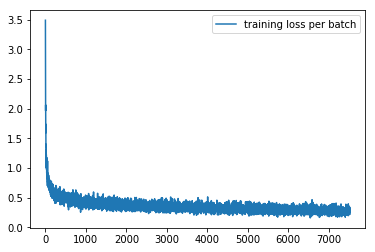

In [33]:
plt.plot(nn_relu_gu_loss_val.losses,label='training loss per batch')
plt.legend()
plt.show()

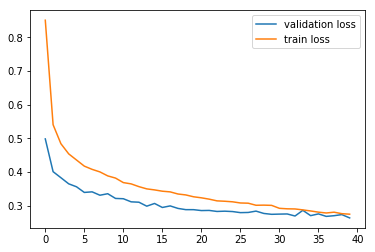

In [34]:
plt.plot(nn_relu_gu_loss_val.val_losses_e,label='validation loss')
plt.plot(nn_relu_gu_loss_val.losses_e,label='train loss')
plt.legend()
plt.show()

In [35]:
prediction = model.predict_classes(X_train)
confusion_matrix(y_train, prediction)

array([[4512,    1,   29,  121,    8,    2,  228,    0,    4,    0],
       [   7, 4709,    1,   51,    2,    0,    0,    0,    1,    1],
       [  52,    0, 4009,   53,  398,    0,  251,    0,    1,    0],
       [  46,    3,   12, 4670,   67,    0,   34,    0,    3,    0],
       [   5,    2,  312,  227, 4020,    0,  188,    1,    5,    0],
       [   0,    0,    0,    0,    0, 4797,    0,   21,    0,    3],
       [ 688,    2,  268,  115,  283,    0, 3412,    0,   11,    0],
       [   0,    0,    0,    0,    0,   11,    0, 4731,    0,   84],
       [   3,    1,    5,    9,    3,    1,   15,    4, 4755,    0],
       [   0,    0,    0,    0,    0,   12,    0,  112,    0, 4618]],
      dtype=int64)

In [36]:
prediction = model.predict_classes(X_val)
confusion_matrix(y_val, prediction)

array([[ 988,    0,    9,   25,    1,    1,   64,    0,    7,    0],
       [   4, 1209,    1,   12,    1,    0,    1,    0,    0,    0],
       [  24,    0, 1016,   15,   87,    0,   94,    0,    0,    0],
       [  14,    3,    5, 1096,   24,    1,   16,    0,    6,    0],
       [   2,    0,   79,   49, 1043,    0,   64,    0,    3,    0],
       [   0,    0,    0,    0,    0, 1157,    0,   16,    0,    6],
       [ 186,    0,   70,   19,   79,    1,  859,    0,    7,    0],
       [   0,    0,    0,    0,    0,   21,    0, 1119,    0,   34],
       [   3,    0,    3,    2,    3,    2,    2,    3, 1186,    0],
       [   0,    0,    0,    0,    0,   12,    0,   30,    0, 1216]],
      dtype=int64)

In [37]:
prediction = model.predict_classes(X_test)
confusion_matrix(y_test, prediction)

array([[885,   0,  10,  28,   3,   3,  66,   0,   5,   0],
       [  2, 973,   0,  19,   3,   0,   2,   0,   1,   0],
       [ 20,   0, 800,  13,  94,   0,  72,   0,   1,   0],
       [ 18,   3,   8, 930,  20,   0,  16,   0,   5,   0],
       [  0,   0,  96,  50, 798,   0,  55,   0,   1,   0],
       [  0,   0,   0,   0,   0, 974,   0,  17,   1,   8],
       [163,   1,  72,  34,  64,   0, 658,   0,   8,   0],
       [  0,   0,   0,   0,   0,  13,   0, 963,   0,  24],
       [  5,   0,   0,   5,   2,   1,   4,   5, 978,   0],
       [  0,   0,   0,   0,   0,   8,   1,  38,   0, 953]], dtype=int64)

In [38]:
score = model.evaluate(X_train, Y_train, verbose=0)
print('Train loss:', score[0])
print('Train accuracy:', score[1])
print('-------------------------------')
score = model.evaluate(X_val, Y_val, verbose=0)
print('Validation loss:', score[0])
print('Validation accuracy:', score[1])
print('-------------------------------')
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train loss: 0.20766194741303723
Train accuracy: 0.9215208333333333
-------------------------------
Validation loss: 0.26325506591796877
Validation accuracy: 0.9074166666666666
-------------------------------
Test loss: 0.3054764089822769
Test accuracy: 0.8912


In [39]:
model = Sequential([
    Dense(1024, input_shape=(784,), activation='linear'),
    keras.layers.LeakyReLU(alpha=.001),
    Dropout(0.63),
    Dense(1024, activation='linear'),
    keras.layers.LeakyReLU(alpha=.001),
    Dropout(0.35),
    Dense(256, activation='linear'),
    keras.layers.LeakyReLU(alpha=.001),
    BatchNormalization(),
    Dropout(0.42),
    Dense(10, activation='softmax')
])

In [40]:
model.compile(optimizer=keras.optimizers.Adam(lr=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [41]:
nn_leaky_relu_loss_val = LossHistory()

nn_leaky_relu_eval = model.fit(X_train, Y_train,
                    batch_size=256,
                    epochs=40,
                    verbose=1,
                    validation_data=(X_val, Y_val),
                    callbacks=[nn_leaky_relu_loss_val])

Train on 48000 samples, validate on 12000 samples
Epoch 1/40
48000/48000 [==============================] - 3s 61us/step - loss: 0.8360 - acc: 0.7127 - val_loss: 0.4647 - val_acc: 0.8345
Epoch 2/40
48000/48000 [==============================] - 2s 43us/step - loss: 0.5401 - acc: 0.8049 - val_loss: 0.4020 - val_acc: 0.8563
Epoch 3/40
48000/48000 [==============================] - 2s 44us/step - loss: 0.4888 - acc: 0.8211 - val_loss: 0.3746 - val_acc: 0.8680
Epoch 4/40
48000/48000 [==============================] - 2s 43us/step - loss: 0.4610 - acc: 0.8333 - val_loss: 0.3638 - val_acc: 0.8695
Epoch 5/40
48000/48000 [==============================] - 2s 43us/step - loss: 0.4392 - acc: 0.8397 - val_loss: 0.3431 - val_acc: 0.8783
Epoch 6/40
48000/48000 [==============================] - 2s 43us/step - loss: 0.4247 - acc: 0.8448 - val_loss: 0.3487 - val_acc: 0.8727
Epoch 7/40
48000/48000 [==============================] - 2s 43us/step - loss: 0.4092 - acc: 0.8490 - val_loss: 0.3466 - val_acc

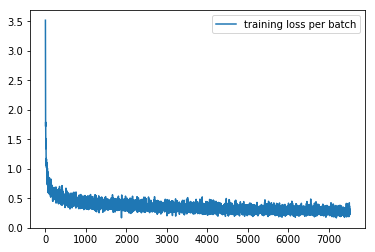

In [42]:
plt.plot(nn_leaky_relu_loss_val.losses,label='training loss per batch')
plt.legend()
plt.show()

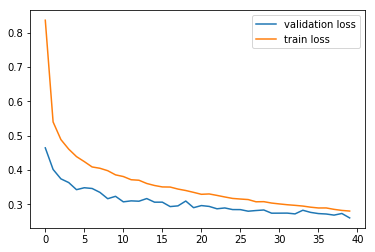

In [43]:
plt.plot(nn_leaky_relu_loss_val.val_losses_e,label='validation loss')
plt.plot(nn_leaky_relu_loss_val.losses_e,label='train loss')
plt.legend()
plt.show()

In [44]:
prediction = model.predict_classes(X_train)
confusion_matrix(y_train, prediction)

array([[4342,    3,   37,   93,    9,    0,  412,    0,    9,    0],
       [   3, 4708,    2,   55,    2,    0,    1,    0,    1,    0],
       [  27,    1, 4050,   53,  372,    0,  255,    0,    6,    0],
       [  69,    8,    9, 4598,  106,    0,   43,    0,    2,    0],
       [   7,    3,  350,  156, 4069,    0,  171,    0,    4,    0],
       [   0,    0,    0,    0,    0, 4791,    0,   29,    0,    1],
       [ 548,    2,  264,   94,  318,    0, 3538,    0,   15,    0],
       [   0,    0,    0,    0,    0,    9,    0, 4758,    0,   59],
       [   2,    0,    7,   13,   10,    2,   15,    0, 4747,    0],
       [   0,    0,    0,    0,    0,    7,    0,  140,    0, 4595]],
      dtype=int64)

In [45]:
prediction = model.predict_classes(X_val)
confusion_matrix(y_val, prediction)

array([[ 944,    0,   10,   25,    1,    0,  105,    0,   10,    0],
       [   1, 1208,    2,   12,    2,    0,    3,    0,    0,    0],
       [  16,    0, 1046,   12,   79,    0,   82,    0,    1,    0],
       [  22,    4,    3, 1086,   35,    0,   13,    0,    2,    0],
       [   2,    0,  100,   34, 1045,    0,   56,    0,    3,    0],
       [   0,    0,    0,    0,    0, 1146,    0,   22,    1,   10],
       [ 152,    1,   77,   17,   78,    0,  887,    0,    9,    0],
       [   0,    0,    0,    0,    0,   20,    0, 1131,    1,   22],
       [   1,    0,    4,    3,    5,    2,    7,    5, 1177,    0],
       [   1,    0,    0,    0,    0,    8,    0,   41,    0, 1208]],
      dtype=int64)

In [46]:
prediction = model.predict_classes(X_test)
confusion_matrix(y_test, prediction)

array([[844,   1,  11,  25,   5,   1, 107,   0,   6,   0],
       [  2, 971,   2,  19,   3,   0,   2,   0,   1,   0],
       [ 13,   1, 818,  12,  80,   0,  75,   0,   1,   0],
       [ 22,   8,   6, 914,  26,   0,  21,   0,   3,   0],
       [  0,   0,  98,  43, 810,   0,  47,   0,   2,   0],
       [  0,   0,   0,   0,   0, 969,   0,  17,   1,  13],
       [135,   0,  81,  29,  73,   0, 674,   0,   8,   0],
       [  0,   0,   0,   0,   0,  13,   0, 972,   0,  15],
       [  4,   0,   1,   6,   2,   2,   4,   2, 979,   0],
       [  0,   0,   0,   0,   0,   8,   1,  40,   0, 951]], dtype=int64)

In [47]:
score = model.evaluate(X_train, Y_train, verbose=0)
print('Train loss:', score[0])
print('Train accuracy:', score[1])
print('-------------------------------')
score = model.evaluate(X_val, Y_val, verbose=0)
print('Validation loss:', score[0])
print('Validation accuracy:', score[1])
print('-------------------------------')
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train loss: 0.21061636835957567
Train accuracy: 0.92075
-------------------------------
Validation loss: 0.2609324606557687
Validation accuracy: 0.9065
-------------------------------
Test loss: 0.3051267783403397
Test accuracy: 0.8902


In [48]:
img_rows = 28
img_cols = 28
input_shape = (img_rows, img_cols, 1)
X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
X_val = X_val.reshape(X_val.shape[0], img_rows, img_cols, 1)

In [49]:
cnn1 = Sequential([
    Conv2D(8, kernel_size=(3, 3), activation='relu',padding='same',input_shape=input_shape),
    MaxPooling2D(pool_size=(2, 2),strides=2),
    Conv2D(16, kernel_size=(5, 5), activation='relu'),
    MaxPooling2D(pool_size=(2, 2),strides=2),
    Flatten(),
    Dense(120, activation='relu'),
    Dense(84, activation='relu'),
    Dense(10, activation='softmax')
])

In [50]:
cnn1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 8)         80        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 16)        3216      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 16)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 400)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 120)               48120     
_________________________________________________________________
dense_15 (Dense)             (None, 84)                10164     
__________

In [51]:
cnn1.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(lr=0.001),
              metrics=['accuracy'])

In [52]:
cnn1_loss_val = LossHistory()
cnn1.fit(X_train, Y_train,
          batch_size=256,
          epochs=15,
          verbose=1,
          validation_data=(X_val, Y_val),
          callbacks=[cnn1_loss_val])

Train on 48000 samples, validate on 12000 samples
Epoch 1/15
48000/48000 [==============================] - 4s 81us/step - loss: 0.7926 - acc: 0.7243 - val_loss: 0.5312 - val_acc: 0.8067
Epoch 2/15
48000/48000 [==============================] - 2s 43us/step - loss: 0.4705 - acc: 0.8299 - val_loss: 0.4082 - val_acc: 0.8548
Epoch 3/15
48000/48000 [==============================] - 2s 44us/step - loss: 0.4064 - acc: 0.8537 - val_loss: 0.3701 - val_acc: 0.8722
Epoch 4/15
48000/48000 [==============================] - 2s 43us/step - loss: 0.3721 - acc: 0.8655 - val_loss: 0.3539 - val_acc: 0.8751
Epoch 5/15
48000/48000 [==============================] - 2s 43us/step - loss: 0.3453 - acc: 0.8748 - val_loss: 0.3475 - val_acc: 0.8784
Epoch 6/15
48000/48000 [==============================] - 2s 42us/step - loss: 0.3238 - acc: 0.8825 - val_loss: 0.3124 - val_acc: 0.8923
Epoch 7/15
48000/48000 [==============================] - 2s 42us/step - loss: 0.3094 - acc: 0.8876 - val_loss: 0.3009 - val_acc

In [53]:
score = cnn1.evaluate(X_train, Y_train, verbose=0)
print('Train loss:', score[0])
print('Train accuracy:', score[1])
print('-------------------------------')
score = cnn1.evaluate(X_val, Y_val, verbose=0)
print('Validation loss:', score[0])
print('Validation accuracy:', score[1])
print('-------------------------------')
score = cnn1.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train loss: 0.22130923046047488
Train accuracy: 0.9177916666666667
-------------------------------
Validation loss: 0.25723454462488493
Validation accuracy: 0.90925
-------------------------------
Test loss: 0.2917709938287735
Test accuracy: 0.8972


In [54]:
cnn1 = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu',input_shape=input_shape),
    MaxPooling2D(pool_size=(2, 2),strides=2),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2),strides=2),
    Conv2D(128, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2),strides=2),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax')
])

In [55]:
cnn1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 3, 3, 128)         73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 1, 1, 128)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 128)               0         
__________

In [56]:
cnn1.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(lr=0.001),
              metrics=['accuracy'])

In [57]:
cnn1_loss_val = LossHistory()
cnn1.fit(X_train, Y_train,
          batch_size=256,
          epochs=15,
          verbose=1,
          validation_data=(X_val, Y_val),
          callbacks=[cnn1_loss_val])

Train on 48000 samples, validate on 12000 samples
Epoch 1/15
48000/48000 [==============================] - 3s 64us/step - loss: 0.8552 - acc: 0.6928 - val_loss: 0.5774 - val_acc: 0.7918
Epoch 2/15
48000/48000 [==============================] - 2s 51us/step - loss: 0.5358 - acc: 0.8030 - val_loss: 0.4671 - val_acc: 0.8312
Epoch 3/15
48000/48000 [==============================] - 2s 51us/step - loss: 0.4602 - acc: 0.8316 - val_loss: 0.4156 - val_acc: 0.8518
Epoch 4/15
48000/48000 [==============================] - 2s 51us/step - loss: 0.4143 - acc: 0.8483 - val_loss: 0.3806 - val_acc: 0.8630
Epoch 5/15
48000/48000 [==============================] - 2s 51us/step - loss: 0.3867 - acc: 0.8585 - val_loss: 0.3750 - val_acc: 0.8637
Epoch 6/15
48000/48000 [==============================] - 2s 52us/step - loss: 0.3595 - acc: 0.8690 - val_loss: 0.3547 - val_acc: 0.8722
Epoch 7/15
48000/48000 [==============================] - 2s 52us/step - loss: 0.3457 - acc: 0.8735 - val_loss: 0.3418 - val_acc

In [58]:
score = cnn1.evaluate(X_train, Y_train, verbose=0)
print('Train loss:', score[0])
print('Train accuracy:', score[1])
print('-------------------------------')
score = cnn1.evaluate(X_val, Y_val, verbose=0)
print('Validation loss:', score[0])
print('Validation accuracy:', score[1])
print('-------------------------------')
score = cnn1.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train loss: 0.23158998483171064
Train accuracy: 0.915
-------------------------------
Validation loss: 0.2915115755001704
Validation accuracy: 0.89475
-------------------------------
Test loss: 0.326910384619236
Test accuracy: 0.8833


In [59]:
cnn1 = Sequential([
    Conv2D(16, kernel_size=(3, 3), activation='relu',padding='same',input_shape=input_shape),
    Conv2D(16, kernel_size=(3, 3), activation='relu',padding='same'),
    MaxPooling2D(pool_size=(2, 2),strides=2),
    Conv2D(32, kernel_size=(3, 3), activation='relu'),
    Conv2D(32, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2),strides=2),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(10, activation='softmax')
])

In [60]:
cnn1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 28, 28, 16)        2320      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 12, 12, 32)        4640      
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 10, 10, 32)        9248      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 800)               0         
__________

In [61]:
cnn1.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(lr=0.001),
              metrics=['accuracy'])

In [62]:
cnn1_loss_val = LossHistory()
cnn1.fit(X_train, Y_train,
          batch_size=256,
          epochs=15,
          verbose=1,
          validation_data=(X_val, Y_val),
          callbacks=[cnn1_loss_val])

Train on 48000 samples, validate on 12000 samples
Epoch 1/15
48000/48000 [==============================] - 4s 74us/step - loss: 0.6403 - acc: 0.7721 - val_loss: 0.3981 - val_acc: 0.8580
Epoch 2/15
48000/48000 [==============================] - 3s 55us/step - loss: 0.3813 - acc: 0.8631 - val_loss: 0.3272 - val_acc: 0.8844
Epoch 3/15
48000/48000 [==============================] - 3s 55us/step - loss: 0.3250 - acc: 0.8820 - val_loss: 0.2888 - val_acc: 0.9005
Epoch 4/15
48000/48000 [==============================] - 3s 55us/step - loss: 0.2879 - acc: 0.8955 - val_loss: 0.2743 - val_acc: 0.9023
Epoch 5/15
48000/48000 [==============================] - 3s 55us/step - loss: 0.2601 - acc: 0.9056 - val_loss: 0.2453 - val_acc: 0.9104
Epoch 6/15
48000/48000 [==============================] - 3s 54us/step - loss: 0.2406 - acc: 0.9120 - val_loss: 0.2607 - val_acc: 0.9105
Epoch 7/15
48000/48000 [==============================] - 3s 55us/step - loss: 0.2220 - acc: 0.9195 - val_loss: 0.2482 - val_acc

In [63]:
score = cnn1.evaluate(X_train, Y_train, verbose=0)
print('Train loss:', score[0])
print('Train accuracy:', score[1])
print('-------------------------------')
score = cnn1.evaluate(X_val, Y_val, verbose=0)
print('Validation loss:', score[0])
print('Validation accuracy:', score[1])
print('-------------------------------')
score = cnn1.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train loss: 0.09648048284626566
Train accuracy: 0.9664583333333333
-------------------------------
Validation loss: 0.23228244352713226
Validation accuracy: 0.92475
-------------------------------
Test loss: 0.25619146502017975
Test accuracy: 0.9189


In [3]:
def data():
    (X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
    
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=12345)
    X_train = X_train.reshape(48000, 784)
    X_val = X_val.reshape(12000, 784)
    X_train = X_train.astype('float32')
    X_val = X_val.astype('float32')
    X_train /= 255
    X_val /= 255
    nb_classes = 10
    Y_train = np_utils.to_categorical(y_train, nb_classes)
    Y_val = np_utils.to_categorical(y_val, nb_classes)
    img_rows = 28
    img_cols = 28
    input_shape = (1, img_rows, img_cols)
    X_train = X_train.reshape(X_train.shape[0],1, img_rows, img_cols)
    X_val = X_val.reshape(X_val.shape[0],1, img_rows, img_cols)
    return X_train, Y_train, X_val, Y_val

In [4]:
def model(X_train, Y_train, X_val, Y_val):
    
    model = Sequential()
    model_choice = {{choice(['one', 'two'])}}
    if model_choice == 'one':
        model.add(Conv2D(16, kernel_size=3, activation='relu',padding='same', input_shape=(1,28,28), data_format='channels_first'))
        model.add(Conv2D(16, kernel_size=3, activation='relu',padding='same'))
        model.add(MaxPooling2D(pool_size=2,strides=2))
        model.add(Dropout({{uniform(0, 1)}}))
        model.add(Conv2D(32, kernel_size=3, activation='relu'))
        model.add(Conv2D(32, kernel_size=3, activation='relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=2,strides=2))
        model.add(Dropout({{uniform(0, 1)}}))
    elif model_choice == 'two':
        model.add(Conv2D(32, kernel_size=3, activation='relu',padding='same', input_shape=(1,28,28), data_format='channels_first'))
        model.add(Conv2D(32, kernel_size=3, activation='relu',padding='same'))
        model.add(MaxPooling2D(pool_size=2,strides=2))
        model.add(Dropout({{uniform(0, 1)}}))
        model.add(Conv2D(64, kernel_size=3, activation='relu'))
        model.add(Conv2D(64, kernel_size=3, activation='relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=2,strides=2))
        model.add(Dropout({{uniform(0, 1)}}))
    
    model.add(Flatten())
    model.add(Dense({{choice([256, 512,1024])}}, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout({{uniform(0, 1)}}))
    choiceval = {{choice(['one', 'two'])}}
    if choiceval == 'two':
        model.add(Dense({{choice([256, 512,1024])}}, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout({{uniform(0, 1)}}))
    
    model.add(Dense(10, activation='softmax'))
    
    adam = keras.optimizers.Adam(lr=0.001)
    
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'],
                  optimizer=adam)
    model.fit(X_train, Y_train,
              batch_size=256,
              nb_epoch=15,
              verbose=2,
              validation_data=(X_val, Y_val))
    score, acc = model.evaluate(X_val, Y_val, verbose=0)
    print('Val accuracy:', acc)
    return {'loss': -acc, 'status': STATUS_OK, 'model': model}

In [5]:
X_train, Y_train, X_val, Y_val = data()
best_run, best_model = optim.minimize(model=model,
                                      data=data,
                                      algo=tpe.suggest,
                                      max_evals=30,
                                      trials=Trials(),
                                      notebook_name='Fashion_MNIST')

>>> Imports:
#coding=utf-8

try:
    import keras
except:
    pass

try:
    from keras.models import Sequential
except:
    pass

try:
    from keras.layers import Dense, Dropout, Flatten, Lambda
except:
    pass

try:
    from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
except:
    pass

try:
    import matplotlib.pyplot as plt
except:
    pass

try:
    import matplotlib.image as mpimg
except:
    pass

try:
    from keras.preprocessing.image import ImageDataGenerator
except:
    pass

try:
    import numpy as np
except:
    pass

try:
    import pandas as pd
except:
    pass

try:
    from keras import optimizers
except:
    pass

try:
    from sklearn.model_selection import GridSearchCV
except:
    pass

try:
    from keras.wrappers.scikit_learn import KerasClassifier
except:
    pass

try:
    from hyperopt import Trials, STATUS_OK, tpe
except:
    pass

try:
    from keras.datasets import fashion_mnist
except:
    pass

try:
    from sklearn.model_selection impo

C:\Users\Shashank R\Anaconda3\lib\site-packages\keras\models.py:942: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 48000 samples, validate on 12000 samples
Epoch 1/15
 - 9s - loss: 1.5285 - acc: 0.5727 - val_loss: 0.8466 - val_acc: 0.6851
Epoch 2/15
 - 5s - loss: 0.7626 - acc: 0.7217 - val_loss: 0.6889 - val_acc: 0.7383
Epoch 3/15
 - 5s - loss: 0.6141 - acc: 0.7729 - val_loss: 0.6050 - val_acc: 0.7812
Epoch 4/15
 - 5s - loss: 0.5534 - acc: 0.7973 - val_loss: 0.5304 - val_acc: 0.8089
Epoch 5/15
 - 5s - loss: 0.5206 - acc: 0.8092 - val_loss: 0.6080 - val_acc: 0.7879
Epoch 6/15
 - 5s - loss: 0.4916 - acc: 0.8167 - val_loss: 0.5144 - val_acc: 0.8172
Epoch 7/15
 - 5s - loss: 0.4715 - acc: 0.8254 - val_loss: 0.4385 - val_acc: 0.8431
Epoch 8/15
 - 5s - loss: 0.4561 - acc: 0.8309 - val_loss: 0.4854 - val_acc: 0.8273
Epoch 9/15
 - 5s - loss: 0.4415 - acc: 0.8356 - val_loss: 0.4892 - val_acc: 0.8261
Epoch 10/15
 - 5s - loss: 0.4361 - acc: 0.8375 - val_loss: 0.4766 - val_acc: 0.8301
Epoch 11/15
 - 5s - loss: 0.4204 - acc: 0.8431 - val_loss: 0.4355 - val_acc: 0.8446
Epoch 12/15
 - 5s - loss: 0.4144 - 

Epoch 3/15
 - 6s - loss: 0.4102 - acc: 0.8491 - val_loss: 0.3281 - val_acc: 0.8799
Epoch 4/15
 - 6s - loss: 0.3734 - acc: 0.8608 - val_loss: 0.3302 - val_acc: 0.8814
Epoch 5/15
 - 6s - loss: 0.3481 - acc: 0.8702 - val_loss: 0.3361 - val_acc: 0.8747
Epoch 6/15
 - 5s - loss: 0.3302 - acc: 0.8748 - val_loss: 0.3066 - val_acc: 0.8874
Epoch 7/15
 - 6s - loss: 0.3150 - acc: 0.8805 - val_loss: 0.3121 - val_acc: 0.8881
Epoch 8/15
 - 6s - loss: 0.3060 - acc: 0.8853 - val_loss: 0.2847 - val_acc: 0.8969
Epoch 9/15
 - 6s - loss: 0.2932 - acc: 0.8891 - val_loss: 0.2990 - val_acc: 0.8907
Epoch 10/15
 - 6s - loss: 0.2814 - acc: 0.8949 - val_loss: 0.3104 - val_acc: 0.8905
Epoch 11/15
 - 6s - loss: 0.2761 - acc: 0.8975 - val_loss: 0.2632 - val_acc: 0.9053
Epoch 12/15
 - 6s - loss: 0.2661 - acc: 0.9010 - val_loss: 0.2782 - val_acc: 0.9001
Epoch 13/15
 - 6s - loss: 0.2574 - acc: 0.9033 - val_loss: 0.2568 - val_acc: 0.9089
Epoch 14/15
 - 6s - loss: 0.2488 - acc: 0.9060 - val_loss: 0.2395 - val_acc: 0.9157

Epoch 6/15
 - 6s - loss: 2.1809 - acc: 0.1613 - val_loss: 2.2372 - val_acc: 0.1054
Epoch 7/15
 - 6s - loss: 2.0786 - acc: 0.1877 - val_loss: 2.2016 - val_acc: 0.1040
Epoch 8/15
 - 6s - loss: 2.0138 - acc: 0.2058 - val_loss: 2.1925 - val_acc: 0.1083
Epoch 9/15
 - 6s - loss: 1.9756 - acc: 0.2159 - val_loss: 2.2913 - val_acc: 0.1057
Epoch 10/15
 - 6s - loss: 1.9395 - acc: 0.2282 - val_loss: 2.3870 - val_acc: 0.1042
Epoch 11/15
 - 6s - loss: 1.9221 - acc: 0.2320 - val_loss: 2.4873 - val_acc: 0.1016
Epoch 12/15
 - 6s - loss: 1.8984 - acc: 0.2440 - val_loss: 2.7041 - val_acc: 0.1030
Epoch 13/15
 - 6s - loss: 1.8767 - acc: 0.2475 - val_loss: 2.7299 - val_acc: 0.0925
Epoch 14/15
 - 6s - loss: 1.8701 - acc: 0.2494 - val_loss: 3.0181 - val_acc: 0.1033
Epoch 15/15
 - 6s - loss: 1.8592 - acc: 0.2573 - val_loss: 3.3314 - val_acc: 0.1030
Val accuracy: 0.103
Train on 48000 samples, validate on 12000 samples
Epoch 1/15
 - 9s - loss: 1.3276 - acc: 0.6092 - val_loss: 1.0269 - val_acc: 0.6412
Epoch 2/15


Epoch 9/15
 - 6s - loss: 0.2836 - acc: 0.8936 - val_loss: 0.3023 - val_acc: 0.8967
Epoch 10/15
 - 7s - loss: 0.2786 - acc: 0.8968 - val_loss: 0.2620 - val_acc: 0.9083
Epoch 11/15
 - 6s - loss: 0.2731 - acc: 0.8969 - val_loss: 0.2538 - val_acc: 0.9110
Epoch 12/15
 - 7s - loss: 0.2580 - acc: 0.9036 - val_loss: 0.2483 - val_acc: 0.9095
Epoch 13/15
 - 6s - loss: 0.2567 - acc: 0.9036 - val_loss: 0.2596 - val_acc: 0.9098
Epoch 14/15
 - 6s - loss: 0.2462 - acc: 0.9066 - val_loss: 0.2712 - val_acc: 0.9060
Epoch 15/15
 - 6s - loss: 0.2410 - acc: 0.9085 - val_loss: 0.2919 - val_acc: 0.8992
Val accuracy: 0.8991666666666667
Train on 48000 samples, validate on 12000 samples
Epoch 1/15
 - 11s - loss: 1.9979 - acc: 0.3643 - val_loss: 3.2744 - val_acc: 0.1690
Epoch 2/15
 - 5s - loss: 1.2092 - acc: 0.5370 - val_loss: 4.2187 - val_acc: 0.1813
Epoch 3/15
 - 5s - loss: 1.0498 - acc: 0.5930 - val_loss: 5.8716 - val_acc: 0.1224
Epoch 4/15
 - 5s - loss: 0.9747 - acc: 0.6206 - val_loss: 5.5307 - val_acc: 0.10

Epoch 12/15
 - 6s - loss: 0.1428 - acc: 0.9452 - val_loss: 0.2962 - val_acc: 0.9074
Epoch 13/15
 - 6s - loss: 0.1329 - acc: 0.9501 - val_loss: 0.3812 - val_acc: 0.8925
Epoch 14/15
 - 6s - loss: 0.1192 - acc: 0.9558 - val_loss: 0.3384 - val_acc: 0.9030
Epoch 15/15
 - 6s - loss: 0.1186 - acc: 0.9556 - val_loss: 0.3435 - val_acc: 0.9029
Val accuracy: 0.9029166666666667
Train on 48000 samples, validate on 12000 samples
Epoch 1/15
 - 13s - loss: 0.8583 - acc: 0.6924 - val_loss: 0.5873 - val_acc: 0.7688
Epoch 2/15
 - 6s - loss: 0.5307 - acc: 0.8040 - val_loss: 0.4959 - val_acc: 0.8188
Epoch 3/15
 - 6s - loss: 0.4539 - acc: 0.8307 - val_loss: 0.3882 - val_acc: 0.8617
Epoch 4/15
 - 6s - loss: 0.4193 - acc: 0.8447 - val_loss: 0.4155 - val_acc: 0.8517
Epoch 5/15
 - 6s - loss: 0.3888 - acc: 0.8540 - val_loss: 0.3869 - val_acc: 0.8623
Epoch 6/15
 - 6s - loss: 0.3745 - acc: 0.8588 - val_loss: 0.3338 - val_acc: 0.8816
Epoch 7/15
 - 6s - loss: 0.3572 - acc: 0.8667 - val_loss: 0.3411 - val_acc: 0.8757

In [6]:
print("Best performing model chosen hyper-parameters:")
print(best_run)

Best performing model chosen hyper-parameters:
{'Dense': 1, 'Dense_1': 2, 'Dropout': 0.3651670673673507, 'Dropout_1': 0.5462404596466595, 'Dropout_2': 0.2210786858629927, 'Dropout_3': 0.24271712442466464, 'Dropout_4': 0.005547479085219964, 'Dropout_5': 0.0032438583954874072, 'model_choice': 1, 'model_choice_1': 0}


In [64]:
cnn_best = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu',padding='same',input_shape=input_shape),
    Conv2D(32, kernel_size=(3, 3), activation='relu',padding='same'),
    MaxPooling2D(pool_size=(2, 2),strides=2),
    Dropout(0.2),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2),strides=2),
    Dropout(0.3),
    Flatten(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.7),
    Dense(10, activation='softmax')
])

In [65]:
cnn_best.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(lr=0.001),
              metrics=['accuracy'])

In [66]:
cnn_best_loss_val = LossHistory()
cnn_best.fit(X_train, Y_train,
          batch_size=256,
          epochs=30,
          verbose=1,
          validation_data=(X_val, Y_val),
          callbacks=[cnn_best_loss_val])

Train on 48000 samples, validate on 12000 samples
Epoch 1/30
48000/48000 [==============================] - 6s 126us/step - loss: 0.8608 - acc: 0.7217 - val_loss: 0.3957 - val_acc: 0.8522
Epoch 2/30
48000/48000 [==============================] - 5s 96us/step - loss: 0.4661 - acc: 0.8308 - val_loss: 0.3249 - val_acc: 0.8821
Epoch 3/30
48000/48000 [==============================] - 5s 95us/step - loss: 0.3920 - acc: 0.8595 - val_loss: 0.2798 - val_acc: 0.9035
Epoch 4/30
48000/48000 [==============================] - 5s 98us/step - loss: 0.3452 - acc: 0.8758 - val_loss: 0.2567 - val_acc: 0.9065
Epoch 5/30
48000/48000 [==============================] - 5s 98us/step - loss: 0.3177 - acc: 0.8863 - val_loss: 0.2476 - val_acc: 0.9057
Epoch 6/30
48000/48000 [==============================] - 5s 97us/step - loss: 0.2986 - acc: 0.8925 - val_loss: 0.2283 - val_acc: 0.9171
Epoch 7/30
48000/48000 [==============================] - 5s 100us/step - loss: 0.2744 - acc: 0.9007 - val_loss: 0.2118 - val_a

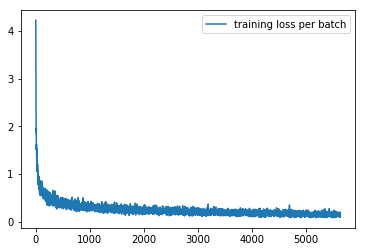

In [73]:
plt.plot(cnn_best_loss_val.losses,label='training loss per batch')
plt.legend()
plt.show()

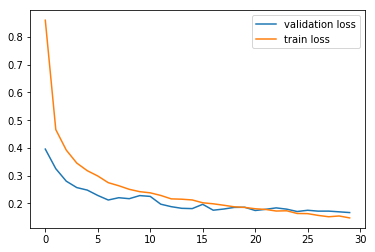

In [74]:
plt.plot(cnn_best_loss_val.val_losses_e,label='validation loss')
plt.plot(cnn_best_loss_val.losses_e,label='train loss')
plt.legend()
plt.show()

In [75]:
prediction = cnn_best.predict_classes(X_train)
confusion_matrix(y_train, prediction)

array([[4676,    1,   39,   37,    0,    1,  148,    0,    3,    0],
       [   0, 4771,    0,    1,    0,    0,    0,    0,    0,    0],
       [  35,    0, 4533,   21,  125,    0,   50,    0,    0,    0],
       [  10,    5,   12, 4727,   68,    0,   13,    0,    0,    0],
       [   2,    1,   73,   26, 4591,    0,   67,    0,    0,    0],
       [   0,    0,    0,    0,    0, 4820,    0,    1,    0,    0],
       [ 264,    1,  134,   52,   93,    0, 4235,    0,    0,    0],
       [   0,    0,    0,    0,    0,    5,    0, 4784,    0,   37],
       [   2,    0,    3,    1,    1,    0,    2,    0, 4787,    0],
       [   0,    0,    0,    0,    0,   11,    0,   48,    0, 4683]],
      dtype=int64)

In [76]:
prediction = cnn_best.predict_classes(X_val)
confusion_matrix(y_val, prediction)

array([[1005,    1,    9,   18,    2,    0,   58,    0,    2,    0],
       [   0, 1219,    1,    4,    1,    0,    2,    0,    1,    0],
       [  22,    0, 1134,    7,   47,    0,   25,    0,    1,    0],
       [  13,    4,    4, 1103,   28,    0,   12,    0,    1,    0],
       [   1,    1,   37,   17, 1126,    0,   58,    0,    0,    0],
       [   0,    0,    0,    0,    0, 1171,    0,    2,    1,    5],
       [  99,    0,   45,   24,   55,    0,  997,    0,    1,    0],
       [   0,    0,    0,    0,    0,    6,    0, 1147,    0,   21],
       [   2,    1,    2,    1,    1,    3,    6,    0, 1188,    0],
       [   0,    0,    0,    0,    0,    7,    0,   23,    0, 1228]],
      dtype=int64)

In [77]:
prediction = cnn_best.predict_classes(X_test)
confusion_matrix(y_test, prediction)

array([[900,   1,  15,  15,   3,   1,  61,   0,   4,   0],
       [  2, 989,   0,   7,   0,   0,   1,   0,   1,   0],
       [ 19,   1, 907,   7,  34,   0,  31,   0,   1,   0],
       [  6,   4,  13, 926,  32,   0,  19,   0,   0,   0],
       [  0,   0,  34,  16, 908,   0,  42,   0,   0,   0],
       [  0,   0,   0,   0,   0, 987,   0,  10,   0,   3],
       [ 86,   0,  43,  25,  61,   0, 782,   0,   3,   0],
       [  0,   0,   0,   0,   0,   6,   0, 978,   0,  16],
       [  1,   0,   0,   4,   2,   1,   1,   0, 991,   0],
       [  0,   0,   0,   0,   0,   9,   0,  28,   0, 963]], dtype=int64)

In [78]:
score = cnn_best.evaluate(X_train, Y_train, verbose=0)
print('Train loss:', score[0])
print('Train accuracy:', score[1])
print('-------------------------------')
score = cnn_best.evaluate(X_val, Y_val, verbose=0)
print('Validation loss:', score[0])
print('Validation accuracy:', score[1])
print('-------------------------------')
score = cnn_best.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train loss: 0.08107194405964886
Train accuracy: 0.9709791666666666
-------------------------------
Validation loss: 0.16651236698776484
Validation accuracy: 0.9431666666666667
-------------------------------
Test loss: 0.19940748929455876
Test accuracy: 0.9331


In [80]:
gen = ImageDataGenerator(rotation_range=8, width_shift_range=0.08, shear_range=0.3,
                               height_shift_range=0.08, zoom_range=0.08)
batches = gen.flow(X_train, Y_train, batch_size=256)
val_batches = gen.flow(X_val, Y_val, batch_size=256)

In [81]:
cnn_best.fit_generator(batches, steps_per_epoch=48000//256, epochs=50,
                    validation_data=val_batches, validation_steps=12000//256)

Epoch 1/50
187/187 [==============================] - 13s 71ms/step - loss: 0.3722 - acc: 0.8664 - val_loss: 0.2840 - val_acc: 0.8941
Epoch 2/50
187/187 [==============================] - 14s 76ms/step - loss: 0.3267 - acc: 0.8831 - val_loss: 0.2591 - val_acc: 0.9046
Epoch 3/50
187/187 [==============================] - 14s 75ms/step - loss: 0.3066 - acc: 0.8901 - val_loss: 0.2545 - val_acc: 0.9087
Epoch 4/50
187/187 [==============================] - 14s 77ms/step - loss: 0.2985 - acc: 0.8918 - val_loss: 0.2426 - val_acc: 0.9116
Epoch 5/50
187/187 [==============================] - 15s 80ms/step - loss: 0.2939 - acc: 0.8939 - val_loss: 0.2514 - val_acc: 0.9085
Epoch 6/50
187/187 [==============================] - 14s 76ms/step - loss: 0.2864 - acc: 0.8950 - val_loss: 0.2362 - val_acc: 0.9158
Epoch 7/50
187/187 [==============================] - 14s 75ms/step - loss: 0.2786 - acc: 0.8987 - val_loss: 0.2232 - val_acc: 0.9201
Epoch 8/50
187/187 [==============================] - 12s 66ms

In [82]:
score = cnn_best.evaluate(X_train, Y_train, verbose=0)
print('Train loss:', score[0])
print('Train accuracy:', score[1])
print('-------------------------------')
score = cnn_best.evaluate(X_val, Y_val, verbose=0)
print('Validation loss:', score[0])
print('Validation accuracy:', score[1])
print('-------------------------------')
score = cnn_best.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train loss: 0.13505398928700016
Train accuracy: 0.9490833333333333
-------------------------------
Validation loss: 0.17895198597262302
Validation accuracy: 0.936
-------------------------------
Test loss: 0.19877800442129373
Test accuracy: 0.9274


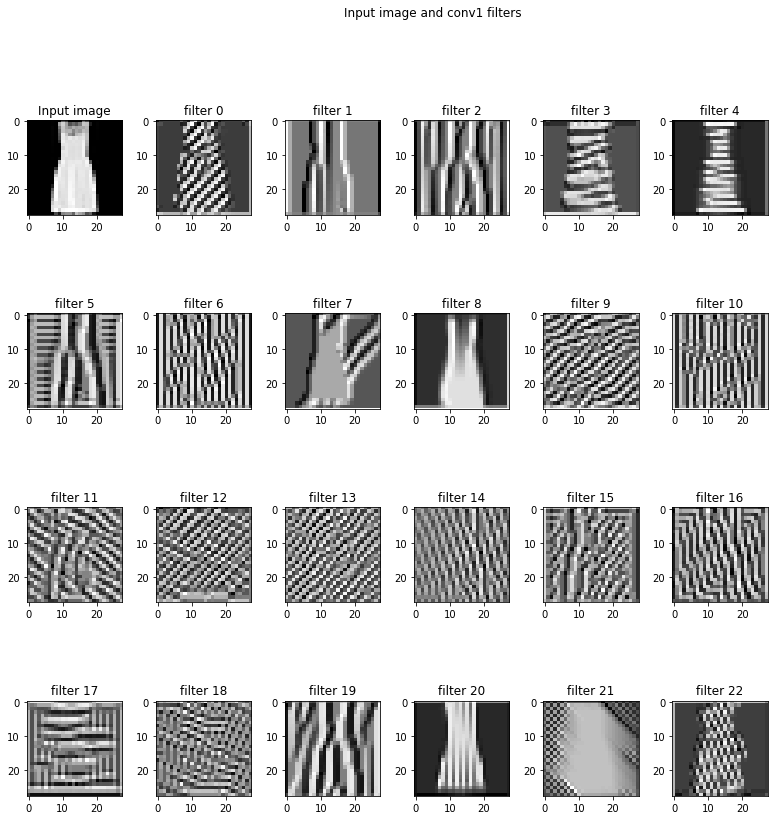

In [119]:
# util function to convert a tensor into a valid image
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    #x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

def vis_img_in_filter(img = np.array(X_train[0]).reshape((1, 28, 28, 1)).astype(np.float64), 
                      layer_name = 'conv1'):
    layer_output = layer_dict[layer_name].output
    img_ascs = list()
    for filter_index in range(layer_output.shape[3]):
        # build a loss function that maximizes the activation
        # of the nth filter of the layer considered
        loss = K.mean(layer_output[:, :, :, filter_index])

        # compute the gradient of the input picture wrt this loss
        grads = K.gradients(loss, model.input)[0]

        # normalization trick: we normalize the gradient
        grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

        # this function returns the loss and grads given the input picture
        iterate = K.function([model.input], [loss, grads])

        # step size for gradient ascent
        step = 5.

        img_asc = np.array(img)
        # run gradient ascent for 20 steps
        for i in range(20):
            loss_value, grads_value = iterate([img_asc])
            img_asc += grads_value * step

        img_asc = img_asc[0]
        img_ascs.append(deprocess_image(img_asc).reshape((28, 28)))
        
    if layer_output.shape[3] >= 35:
        plot_x, plot_y = 6, 6
    elif layer_output.shape[3] >= 23:
        plot_x, plot_y = 4, 6
    elif layer_output.shape[3] >= 11:
        plot_x, plot_y = 2, 6
    else:
        plot_x, plot_y = 1, 2
    fig, ax = plt.subplots(plot_x, plot_y, figsize = (12, 12))
    ax[0, 0].imshow(img.reshape((28, 28)), cmap = 'gray')
    ax[0, 0].set_title('Input image')
    fig.suptitle('Input image and %s filters' % (layer_name,))
    fig.tight_layout(pad = 0.3, rect = [0, 0, 0.9, 0.9])
    for (x, y) in [(i, j) for i in range(plot_x) for j in range(plot_y)]:
        if x == 0 and y == 0:
            continue
        ax[x, y].imshow(img_ascs[x * plot_y + y - 1], cmap = 'gray')
        ax[x, y].set_title('filter %d' % (x * plot_y + y - 1))

vis_img_in_filter()

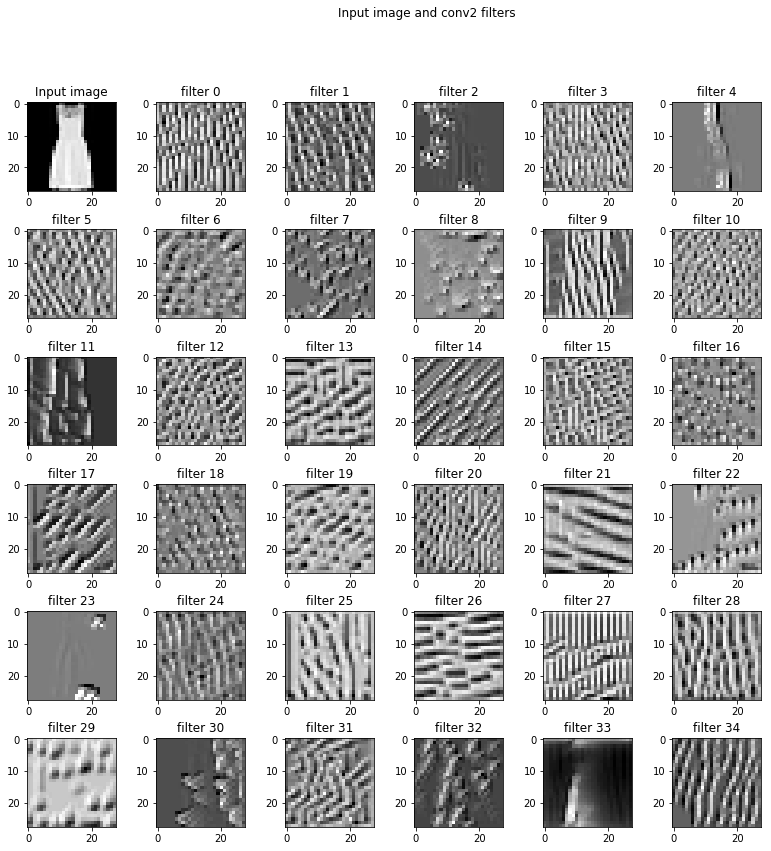

In [120]:
# util function to convert a tensor into a valid image
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    #x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

def vis_img_in_filter(img = np.array(X_train[0]).reshape((1, 28, 28, 1)).astype(np.float64), 
                      layer_name = 'conv2'):
    layer_output = layer_dict[layer_name].output
    img_ascs = list()
    for filter_index in range(layer_output.shape[3]):
        # build a loss function that maximizes the activation
        # of the nth filter of the layer considered
        loss = K.mean(layer_output[:, :, :, filter_index])

        # compute the gradient of the input picture wrt this loss
        grads = K.gradients(loss, model.input)[0]

        # normalization trick: we normalize the gradient
        grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

        # this function returns the loss and grads given the input picture
        iterate = K.function([model.input], [loss, grads])

        # step size for gradient ascent
        step = 5.

        img_asc = np.array(img)
        # run gradient ascent for 20 steps
        for i in range(20):
            loss_value, grads_value = iterate([img_asc])
            img_asc += grads_value * step

        img_asc = img_asc[0]
        img_ascs.append(deprocess_image(img_asc).reshape((28, 28)))
        
    if layer_output.shape[3] >= 35:
        plot_x, plot_y = 6, 6
    elif layer_output.shape[3] >= 23:
        plot_x, plot_y = 4, 6
    elif layer_output.shape[3] >= 11:
        plot_x, plot_y = 2, 6
    else:
        plot_x, plot_y = 1, 2
    fig, ax = plt.subplots(plot_x, plot_y, figsize = (12, 12))
    ax[0, 0].imshow(img.reshape((28, 28)), cmap = 'gray')
    ax[0, 0].set_title('Input image')
    fig.suptitle('Input image and %s filters' % (layer_name,))
    fig.tight_layout(pad = 0.3, rect = [0, 0, 0.9, 0.9])
    for (x, y) in [(i, j) for i in range(plot_x) for j in range(plot_y)]:
        if x == 0 and y == 0:
            continue
        ax[x, y].imshow(img_ascs[x * plot_y + y - 1], cmap = 'gray')
        ax[x, y].set_title('filter %d' % (x * plot_y + y - 1))

vis_img_in_filter()

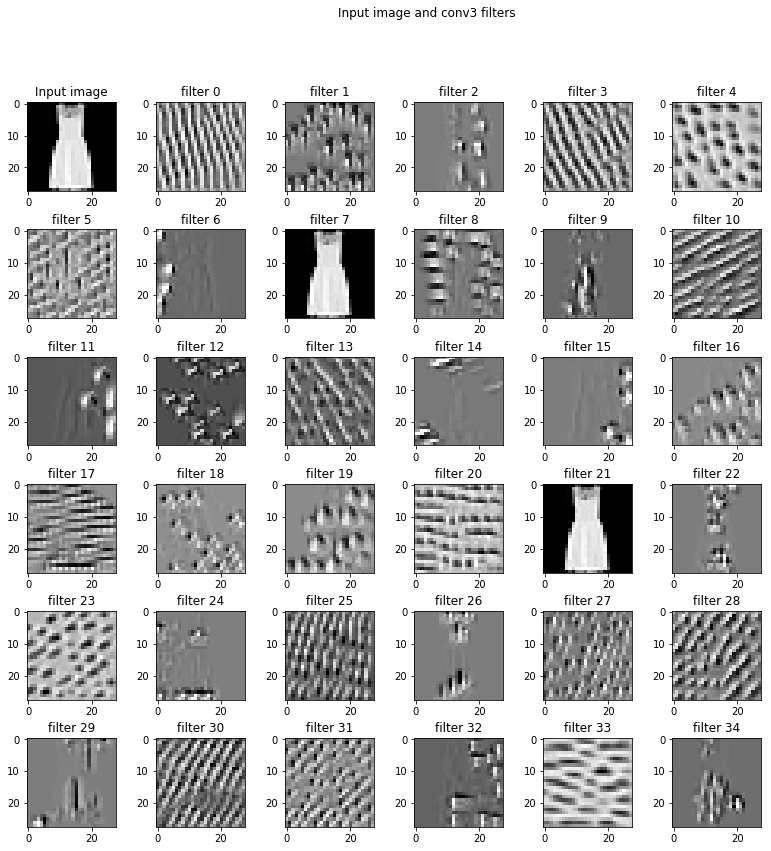

In [118]:
# util function to convert a tensor into a valid image
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    #x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

def vis_img_in_filter(img = np.array(X_train[0]).reshape((1, 28, 28, 1)).astype(np.float64), 
                      layer_name = 'conv3'):
    layer_output = layer_dict[layer_name].output
    img_ascs = list()
    for filter_index in range(layer_output.shape[3]):
        # build a loss function that maximizes the activation
        # of the nth filter of the layer considered
        loss = K.mean(layer_output[:, :, :, filter_index])

        # compute the gradient of the input picture wrt this loss
        grads = K.gradients(loss, model.input)[0]

        # normalization trick: we normalize the gradient
        grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

        # this function returns the loss and grads given the input picture
        iterate = K.function([model.input], [loss, grads])

        # step size for gradient ascent
        step = 5.

        img_asc = np.array(img)
        # run gradient ascent for 20 steps
        for i in range(20):
            loss_value, grads_value = iterate([img_asc])
            img_asc += grads_value * step

        img_asc = img_asc[0]
        img_ascs.append(deprocess_image(img_asc).reshape((28, 28)))
        
    if layer_output.shape[3] >= 35:
        plot_x, plot_y = 6, 6
    elif layer_output.shape[3] >= 23:
        plot_x, plot_y = 4, 6
    elif layer_output.shape[3] >= 11:
        plot_x, plot_y = 2, 6
    else:
        plot_x, plot_y = 1, 2
    fig, ax = plt.subplots(plot_x, plot_y, figsize = (12, 12))
    ax[0, 0].imshow(img.reshape((28, 28)), cmap = 'gray')
    ax[0, 0].set_title('Input image')
    fig.suptitle('Input image and %s filters' % (layer_name,))
    fig.tight_layout(pad = 0.3, rect = [0, 0, 0.9, 0.9])
    for (x, y) in [(i, j) for i in range(plot_x) for j in range(plot_y)]:
        if x == 0 and y == 0:
            continue
        ax[x, y].imshow(img_ascs[x * plot_y + y - 1], cmap = 'gray')
        ax[x, y].set_title('filter %d' % (x * plot_y + y - 1))

vis_img_in_filter()